## MNIST autoencoder: unsupervised clustering


In [187]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D, Conv2DTranspose, Reshape, concatenate 
from tensorflow.keras import utils, losses, optimizers, callbacks, regularizers
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from tensorflow import reduce_sum, abs as tf_abs, add as tf_add
%matplotlib notebook

### Load in MNIST and normalise.

In [194]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = np.expand_dims(x_train, 3)
x_test = np.expand_dims(x_test, 3)

x_train[x_train>=0.5] = 1.0
x_train[x_train<0.5] = 0

x_val = x_train[50000:, :, :, :]
y_val = y_train[50000:]
x_train = x_train[:50000, :, :, :]
y_train = y_train[:50000]

# One hot, in case we need it later
num_classes = 10
y_train_onehot = utils.to_categorical(y_train, num_classes)
y_val_onehot = utils.to_categorical(y_val, num_classes)
y_test_onehot = utils.to_categorical(y_val, num_classes)

data_shape = x_train.shape[1:]

### Create our model
I want a U-net-esque model that starts at 28,28 and 

In [296]:
def model1(data):
    
    # DOWN bloc 1
    c1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_1', kernel_regularizer=regularizers.l2(0.01))(data)
    c2 = Conv2D(32, (3, 3), activation='relu', name='Conv_2', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c1)
    p2 = MaxPooling2D(pool_size=(2, 2), name='Pool_2')(c2)
    d2 = Dropout(0.5, name='Dropout_2')(p2)
    
    # DOWN bloc 2
    c3 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_3', kernel_regularizer=regularizers.l2(0.01))(d2)
    c4 = Conv2D(32, (3, 3), activation='relu', name='Conv_4', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c3)
    p4 = MaxPooling2D(pool_size=(2, 2), name='Pool_4')(c4)
    d4 = Dropout(0.5, name='Dropout_4')(p4)
    
    # DOWN bloc 3
    c5 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_5', kernel_regularizer=regularizers.l2(0.01))(d4)
    c6 = Conv2D(32, (3, 3), activation='relu', name='Conv_6', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c5)
#     p6 = MaxPooling2D(pool_size=(2, 2), name='Pool_6')(c6)
#     d6 = Dropout(0.5, name='Dropout_6')(p6)
    
    # Dense layer at bottom
    f7 = Flatten(name='Flatten_7')(c6)
    dense7 = Dense(50, activation='relu', name='Dense_7')(f7)
    dense8 = Dense(784, activation='relu', name='Dense_8')(dense7)
    reshape8 = Reshape((7, 7, 16), name='Reshape_8')(dense8)
    
    # Upward bloc one
    c9 = concatenate([reshape8, c6])
    d9 = Dropout(0.5, name='Dropout_9')(c9)
    c10 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                      name='Conv_10', kernel_regularizer=regularizers.l2(0.01))(d9)
    c11 = Conv2D(16, (3, 3), activation='relu', name='Conv_11', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c10)
    
    # Upward bloc two
    u12 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', name='UpConv_12') (c11)
    c12 = concatenate([c4, u12])
    d12 = Dropout(0.5, name='Dropout_12')(c12)
    c13 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_13', kernel_regularizer=regularizers.l2(0.01))(d12)
    c14 = Conv2D(16, (3, 3), activation='relu', name='Conv_14', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c13)

    # Upward bloc three
    u15 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', name='UpConv_15') (c14)
    c15 = concatenate([c2, u15])
    d15 = Dropout(0.5, name='Dropout_15')(c15)
    c16 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_16', kernel_regularizer=regularizers.l2(0.01))(d15)
    c17 = Conv2D(16, (3, 3), activation='relu', name='Conv_17', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c16)  

    # Prep output
    c18 = Conv2D(1, (1, 1), activation='relu', name='Conv_18', padding='same', 
                kernel_regularizer=regularizers.l2(0.01))(c17)
    
    outputs = c18
    model = Model(inputs=[data], outputs=[outputs])
    return model

def model2(data):
    # Remove last skip connection
    # DOWN bloc 1
    c1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_1', kernel_regularizer=regularizers.l2(0.01))(data)
    c2 = Conv2D(32, (3, 3), activation='relu', name='Conv_2', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c1)
    p2 = MaxPooling2D(pool_size=(2, 2), name='Pool_2')(c2)
    d2 = Dropout(0.5, name='Dropout_2')(p2)
    
    # DOWN bloc 2
    c3 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_3', kernel_regularizer=regularizers.l2(0.01))(d2)
    c4 = Conv2D(32, (3, 3), activation='relu', name='Conv_4', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c3)
    p4 = MaxPooling2D(pool_size=(2, 2), name='Pool_4')(c4)
    d4 = Dropout(0.5, name='Dropout_4')(p4)
    
    # DOWN bloc 3
    c5 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_5', kernel_regularizer=regularizers.l2(0.01))(d4)
    c6 = Conv2D(32, (3, 3), activation='relu', name='Conv_6', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c5)
#     p6 = MaxPooling2D(pool_size=(2, 2), name='Pool_6')(c6)
#     d6 = Dropout(0.5, name='Dropout_6')(p6)
    
    # Dense layer at bottom
    f7 = Flatten(name='Flatten_7')(c6)
    dense7 = Dense(50, activation='relu', name='Dense_7')(f7)
    dense8 = Dense(784, activation='relu', name='Dense_8')(dense7)
    reshape8 = Reshape((7, 7, 16), name='Reshape_8')(dense8)
    
    # Upward bloc one
    c9 = concatenate([reshape8, c6])
    d9 = Dropout(0.5, name='Dropout_9')(c9)
    c10 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                      name='Conv_10', kernel_regularizer=regularizers.l2(0.01))(d9)
    c11 = Conv2D(16, (3, 3), activation='relu', name='Conv_11', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c10)
    
    # Upward bloc two
    u12 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', name='UpConv_12') (c11)
    c12 = concatenate([c4, u12])
    d12 = Dropout(0.5, name='Dropout_12')(c12)
    c13 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_13', kernel_regularizer=regularizers.l2(0.01))(d12)
    c14 = Conv2D(16, (3, 3), activation='relu', name='Conv_14', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c13)

    # Upward bloc three
    u15 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', name='UpConv_15') (c14)
#     c15 = concatenate([c2, u15])
    d15 = Dropout(0.5, name='Dropout_15')(u15)
    c16 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_16', kernel_regularizer=regularizers.l2(0.01))(d15)
    c17 = Conv2D(16, (3, 3), activation='relu', name='Conv_17', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c16)  

    # Prep output
    c18 = Conv2D(1, (1, 1), activation='relu', name='Conv_18', padding='same', 
                kernel_regularizer=regularizers.l2(0.01))(c17)
    
    outputs = c18
    model = Model(inputs=[data], outputs=[outputs])
    return model

def model3(data):
    # Remove middle and last skip connection
    # DOWN bloc 1
    c1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_1', kernel_regularizer=regularizers.l2(0.01))(data)
    c2 = Conv2D(32, (3, 3), activation='relu', name='Conv_2', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c1)
    p2 = MaxPooling2D(pool_size=(2, 2), name='Pool_2')(c2)
    d2 = Dropout(0.5, name='Dropout_2')(p2)
    
    # DOWN bloc 2
    c3 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_3', kernel_regularizer=regularizers.l2(0.01))(d2)
    c4 = Conv2D(32, (3, 3), activation='relu', name='Conv_4', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c3)
    p4 = MaxPooling2D(pool_size=(2, 2), name='Pool_4')(c4)
    d4 = Dropout(0.5, name='Dropout_4')(p4)
    
    # DOWN bloc 3
    c5 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_5', kernel_regularizer=regularizers.l2(0.01))(d4)
    c6 = Conv2D(32, (3, 3), activation='relu', name='Conv_6', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c5)
#     p6 = MaxPooling2D(pool_size=(2, 2), name='Pool_6')(c6)
#     d6 = Dropout(0.5, name='Dropout_6')(p6)
    
    # Dense layer at bottom
    f7 = Flatten(name='Flatten_7')(c6)
    dense7 = Dense(50, activation='relu', name='Dense_7')(f7)
    dense8 = Dense(784, activation='relu', name='Dense_8')(dense7)
    reshape8 = Reshape((7, 7, 16), name='Reshape_8')(dense8)
    
    # Upward bloc one
    c9 = concatenate([reshape8, c6])
    d9 = Dropout(0.5, name='Dropout_9')(c9)
    c10 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                      name='Conv_10', kernel_regularizer=regularizers.l2(0.01))(d9)
    c11 = Conv2D(16, (3, 3), activation='relu', name='Conv_11', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c10)
    
    # Upward bloc two
    u12 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', name='UpConv_12') (c11)
#     c12 = concatenate([c4, u12])
    d12 = Dropout(0.5, name='Dropout_12')(u12)
    c13 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_13', kernel_regularizer=regularizers.l2(0.01))(d12)
    c14 = Conv2D(16, (3, 3), activation='relu', name='Conv_14', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c13)

    # Upward bloc three
    u15 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', name='UpConv_15') (c14)
#     c15 = concatenate([c2, u15])
    d15 = Dropout(0.5, name='Dropout_15')(u15)
    c16 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_16', kernel_regularizer=regularizers.l2(0.01))(d15)
    c17 = Conv2D(16, (3, 3), activation='relu', name='Conv_17', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c16)  

    # Prep output
    c18 = Conv2D(1, (1, 1), activation='relu', name='Conv_18', padding='same', 
                kernel_regularizer=regularizers.l2(0.01))(c17)
    
    outputs = c18
    model = Model(inputs=[data], outputs=[outputs])
    return model

def model4(data):
    # Remove all skip connection
    # DOWN bloc 1
    c1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_1', kernel_regularizer=regularizers.l2(0.01))(data)
    c2 = Conv2D(32, (3, 3), activation='relu', name='Conv_2', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c1)
    p2 = MaxPooling2D(pool_size=(2, 2), name='Pool_2')(c2)
    d2 = Dropout(0.5, name='Dropout_2')(p2)
    
    # DOWN bloc 2
    c3 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_3', kernel_regularizer=regularizers.l2(0.01))(d2)
    c4 = Conv2D(32, (3, 3), activation='relu', name='Conv_4', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c3)
    p4 = MaxPooling2D(pool_size=(2, 2), name='Pool_4')(c4)
    d4 = Dropout(0.5, name='Dropout_4')(p4)
    
    # DOWN bloc 3
    c5 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_5', kernel_regularizer=regularizers.l2(0.01))(d4)
    c6 = Conv2D(32, (3, 3), activation='relu', name='Conv_6', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c5)
#     p6 = MaxPooling2D(pool_size=(2, 2), name='Pool_6')(c6)
#     d6 = Dropout(0.5, name='Dropout_6')(p6)
    
    # Dense layer at bottom
    f7 = Flatten(name='Flatten_7')(c6)
    dense7 = Dense(50, activation='relu', name='Dense_7')(f7)
    dense8 = Dense(784, activation='relu', name='Dense_8')(dense7)
    reshape8 = Reshape((7, 7, 16), name='Reshape_8')(dense8)
    
    # Upward bloc one
#     c9 = concatenate([reshape8, c6])
    d9 = Dropout(0.5, name='Dropout_9')(reshape8)
    c10 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                      name='Conv_10', kernel_regularizer=regularizers.l2(0.01))(d9)
    c11 = Conv2D(16, (3, 3), activation='relu', name='Conv_11', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c10)
    
    # Upward bloc two
    u12 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', name='UpConv_12') (c11)
#     c12 = concatenate([c4, u12])
    d12 = Dropout(0.5, name='Dropout_12')(u12)
    c13 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_13', kernel_regularizer=regularizers.l2(0.01))(d12)
    c14 = Conv2D(16, (3, 3), activation='relu', name='Conv_14', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c13)

    # Upward bloc three
    u15 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', name='UpConv_15') (c14)
#     c15 = concatenate([c2, u15])
    d15 = Dropout(0.5, name='Dropout_15')(u15)
    c16 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_16', kernel_regularizer=regularizers.l2(0.01))(d15)
    c17 = Conv2D(16, (3, 3), activation='relu', name='Conv_17', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c16)  

    # Prep output
    c18 = Conv2D(1, (1, 1), activation='relu', name='Conv_18', padding='same', 
                kernel_regularizer=regularizers.l2(0.01))(c17)
    
    outputs = c18
    model = Model(inputs=[data], outputs=[outputs])
    return model

def model5(data):
    # Remove all skip connections. Remove dropout on up blocs
    # DOWN bloc 1
    c1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_1', kernel_regularizer=regularizers.l2(0.01))(data)
    c2 = Conv2D(32, (3, 3), activation='relu', name='Conv_2', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c1)
    p2 = MaxPooling2D(pool_size=(2, 2), name='Pool_2')(c2)
    d2 = Dropout(0.5, name='Dropout_2')(p2)
    
    # DOWN bloc 2
    c3 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_3', kernel_regularizer=regularizers.l2(0.01))(d2)
    c4 = Conv2D(32, (3, 3), activation='relu', name='Conv_4', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c3)
    p4 = MaxPooling2D(pool_size=(2, 2), name='Pool_4')(c4)
    d4 = Dropout(0.5, name='Dropout_4')(p4)
    
    # DOWN bloc 3
    c5 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_5', kernel_regularizer=regularizers.l2(0.01))(d4)
    c6 = Conv2D(32, (3, 3), activation='relu', name='Conv_6', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c5)
#     p6 = MaxPooling2D(pool_size=(2, 2), name='Pool_6')(c6)
#     d6 = Dropout(0.5, name='Dropout_6')(p6)
    
    # Dense layer at bottom
    f7 = Flatten(name='Flatten_7')(c6)
    dense7 = Dense(80, activation='relu', name='Dense_7')(f7)
    dense8 = Dense(784, activation='relu', name='Dense_8')(dense7)
    reshape8 = Reshape((7, 7, 16), name='Reshape_8')(dense8)
    
    # Upward bloc one
#     c9 = concatenate([reshape8, c6])
#     d9 = Dropout(0.5, name='Dropout_9')(reshape8)
    c10 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                      name='Conv_10', kernel_regularizer=regularizers.l2(0.01))(reshape8)
    c11 = Conv2D(16, (3, 3), activation='relu', name='Conv_11', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c10)
    
    # Upward bloc two
    u12 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', name='UpConv_12') (c11)
#     c12 = concatenate([c4, u12])
#     d12 = Dropout(0.5, name='Dropout_12')(u12)
    c13 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_13', kernel_regularizer=regularizers.l2(0.01))(u12)
    c14 = Conv2D(16, (3, 3), activation='relu', name='Conv_14', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c13)

    # Upward bloc three
    u15 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', name='UpConv_15') (c14)
#     c15 = concatenate([c2, u15])
#     d15 = Dropout(0.5, name='Dropout_15')(u15)
    c16 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_16', kernel_regularizer=regularizers.l2(0.01))(u15)
    c17 = Conv2D(16, (3, 3), activation='relu', name='Conv_17', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c16)  

    # Prep output
    c18 = Conv2D(1, (1, 1), activation='relu', name='Conv_18', padding='same', 
                kernel_regularizer=regularizers.l2(0.01))(c17)
    
    outputs = c18
    model = Model(inputs=[data], outputs=[outputs])
    return model

def model6(data):
    # Remove all skip connections. Remove dropout on up blocs
    # Simplify up blocs
    # DOWN bloc 1
    c1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_1', kernel_regularizer=regularizers.l2(0.01))(data)
    c2 = Conv2D(32, (3, 3), activation='relu', name='Conv_2', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c1)
    p2 = MaxPooling2D(pool_size=(2, 2), name='Pool_2')(c2)
    d2 = Dropout(0.5, name='Dropout_2')(p2)
    
    # DOWN bloc 2
    c3 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_3', kernel_regularizer=regularizers.l2(0.01))(d2)
    c4 = Conv2D(32, (3, 3), activation='relu', name='Conv_4', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c3)
    p4 = MaxPooling2D(pool_size=(2, 2), name='Pool_4')(c4)
    d4 = Dropout(0.5, name='Dropout_4')(p4)
    
    # DOWN bloc 3
    c5 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_5', kernel_regularizer=regularizers.l2(0.01))(d4)
    c6 = Conv2D(32, (3, 3), activation='relu', name='Conv_6', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c5)
#     p6 = MaxPooling2D(pool_size=(2, 2), name='Pool_6')(c6)
#     d6 = Dropout(0.5, name='Dropout_6')(p6)
    
    # Dense layer at bottom
    f7 = Flatten(name='Flatten_7')(c6)
    dense7 = Dense(80, activation='relu', name='Dense_7')(f7)
    dense8 = Dense(784, activation='relu', name='Dense_8')(dense7)
    reshape8 = Reshape((7, 7, 16), name='Reshape_8')(dense8)
    
    # Upward bloc one
#     c9 = concatenate([reshape8, c6])
#     d9 = Dropout(0.5, name='Dropout_9')(reshape8)
    c10 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                      name='Conv_10', kernel_regularizer=regularizers.l2(0.01))(reshape8)
#     c11 = Conv2D(16, (3, 3), activation='relu', name='Conv_11', padding='same', 
#                      kernel_regularizer=regularizers.l2(0.01))(c10)
    
    # Upward bloc two
    u12 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', name='UpConv_12') (c10)
#     c12 = concatenate([c4, u12])
#     d12 = Dropout(0.5, name='Dropout_12')(u12)
    c13 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_13', kernel_regularizer=regularizers.l2(0.01))(u12)
#     c14 = Conv2D(16, (3, 3), activation='relu', name='Conv_14', padding='same', 
#                      kernel_regularizer=regularizers.l2(0.01))(c13)

    # Upward bloc three
    u15 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', name='UpConv_15') (c13)
#     c15 = concatenate([c2, u15])
#     d15 = Dropout(0.5, name='Dropout_15')(u15)
    c16 = Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_16', kernel_regularizer=regularizers.l2(0.01))(u15)
#     c17 = Conv2D(16, (3, 3), activation='relu', name='Conv_17', padding='same', 
#                      kernel_regularizer=regularizers.l2(0.01))(c16)  

    # Prep output
    c18 = Conv2D(1, (1, 1), activation='relu', name='Conv_18', padding='same', 
                kernel_regularizer=regularizers.l2(0.01))(c16)
    
    outputs = c18
    model = Model(inputs=[data], outputs=[outputs])
    return model

def model7(data):
    # Remove all skip connections. Remove dropout on up blocs
    # Simplify up blocs
    # Remove dropout
    # DOWN bloc 1
    c1 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_1', kernel_regularizer=regularizers.l2(0.01))(data)
    c2 = Conv2D(32, (3, 3), activation='relu', name='Conv_2', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c1)
    p2 = MaxPooling2D(pool_size=(2, 2), name='Pool_2')(c2)
    
    # DOWN bloc 2
    c3 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_3', kernel_regularizer=regularizers.l2(0.01))(p2)
    c4 = Conv2D(32, (3, 3), activation='relu', name='Conv_4', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c3)
    p4 = MaxPooling2D(pool_size=(2, 2), name='Pool_4')(c4)
    
    # DOWN bloc 3
    c5 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_5', kernel_regularizer=regularizers.l2(0.01))(p4)
    c6 = Conv2D(32, (3, 3), activation='relu', name='Conv_6', padding='same', 
                     kernel_regularizer=regularizers.l2(0.01))(c5)
    
    # Dense layer at bottom
    f7 = Flatten(name='Flatten_7')(c6)
    dense7 = Dense(240, activation='relu', name='Dense_7')(f7)
    dense8 = Dense(784, activation='relu', name='Dense_8')(dense7)
    reshape8 = Reshape((7, 7, 16), name='Reshape_8')(dense8)
    
    # Upward bloc one
    c10 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                      name='Conv_10', kernel_regularizer=regularizers.l2(0.01))(reshape8)
    
    # Upward bloc two
    u12 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', name='UpConv_12') (c10)
    c13 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_13', kernel_regularizer=regularizers.l2(0.01))(u12)

    # Upward bloc three
    u15 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', name='UpConv_15') (c13)
    c16 = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', 
                     name='Conv_16', kernel_regularizer=regularizers.l2(0.01))(u15)

    # Prep output
    c18 = Conv2D(1, (1, 1), activation='relu', name='Conv_18', padding='same', 
                kernel_regularizer=regularizers.l2(0.01))(c16)
    
    outputs = c18
    model = Model(inputs=[data], outputs=[outputs])
    return model

In [297]:
def custom_loss(y_true, y_pred):
    loss = tf_add(losses.mae(y_true, y_pred),tf_abs(reduce_sum(y_true) - reduce_sum(y_pred)))
    return loss

input_img = Input(data_shape, name='img')
model = model7(input_img)

# model.compile(loss=custom_loss,
#               optimizer=optimizers.Adam(lr=0.001), metrics=['mae'])
model.compile(loss=losses.binary_crossentropy,
              optimizer=optimizers.Adam(lr=0.0001), metrics=['mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 28, 28, 1)         0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 28, 28, 32)        9248      
_________________________________________________________________
Pool_2 (MaxPooling2D)        (None, 14, 14, 32)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 14, 14, 32)        9248      
_________________________________________________________________
Conv_4 (Conv2D)              (None, 14, 14, 32)        9248      
_________________________________________________________________
Pool_4 (MaxPooling2D)        (None, 7, 7, 32)          0         
__________

### Train the model

In [300]:
earlystop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto', 
                                    baseline=None)
history = model.fit(x_train, x_train, batch_size=1024, epochs=100,
          verbose=2, validation_data=(x_val, x_val), callbacks=[earlystop])


Train on 50000 samples, validate on 10000 samples
Epoch 1/100
 - 7s - loss: 1.4552 - mean_absolute_error: 0.1690 - val_loss: 1.3839 - val_mean_absolute_error: 0.1674
Epoch 2/100
 - 6s - loss: 1.3212 - mean_absolute_error: 0.1664 - val_loss: 1.2561 - val_mean_absolute_error: 0.1657
Epoch 3/100
 - 6s - loss: 1.1983 - mean_absolute_error: 0.1635 - val_loss: 1.1399 - val_mean_absolute_error: 0.1644
Epoch 4/100
 - 6s - loss: 1.0867 - mean_absolute_error: 0.1597 - val_loss: 1.0331 - val_mean_absolute_error: 0.1560
Epoch 5/100
 - 6s - loss: 0.9855 - mean_absolute_error: 0.1539 - val_loss: 0.9385 - val_mean_absolute_error: 0.1515
Epoch 6/100
 - 6s - loss: 0.8978 - mean_absolute_error: 0.1510 - val_loss: 0.8578 - val_mean_absolute_error: 0.1501
Epoch 7/100
 - 6s - loss: 0.8196 - mean_absolute_error: 0.1479 - val_loss: 0.7815 - val_mean_absolute_error: 0.1451
Epoch 8/100
 - 6s - loss: 0.7473 - mean_absolute_error: 0.1420 - val_loss: 0.7134 - val_mean_absolute_error: 0.1408
Epoch 9/100
 - 6s - lo

<IPython.core.display.Javascript object>


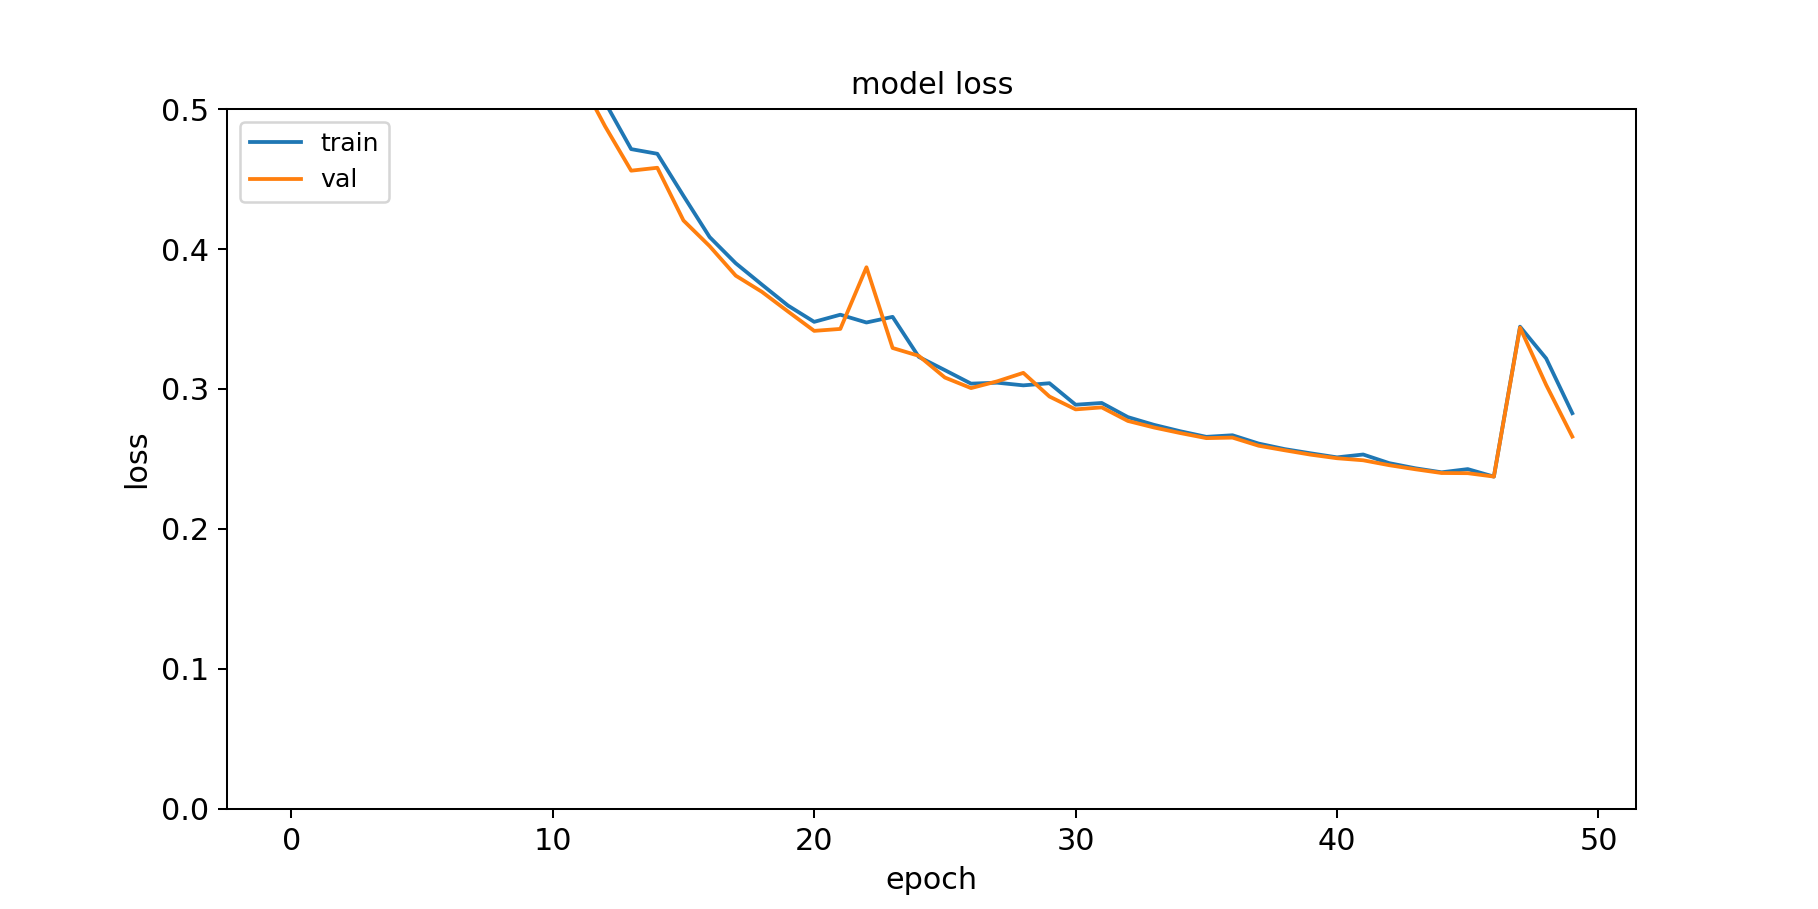

In [301]:
# Make nice printed output showing loss plot and results.
# print(history.history.keys())
# plt.plot(history.history['mean_squared_error'])
# plt.plot(history.history['val_mean_squared_error'])
# plt.title('model mse')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim([0, 0.5])
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('/data/imgs/mnist-autoencoder_loss.png', dpi=200)



### Look at some outputs

<IPython.core.display.Javascript object>


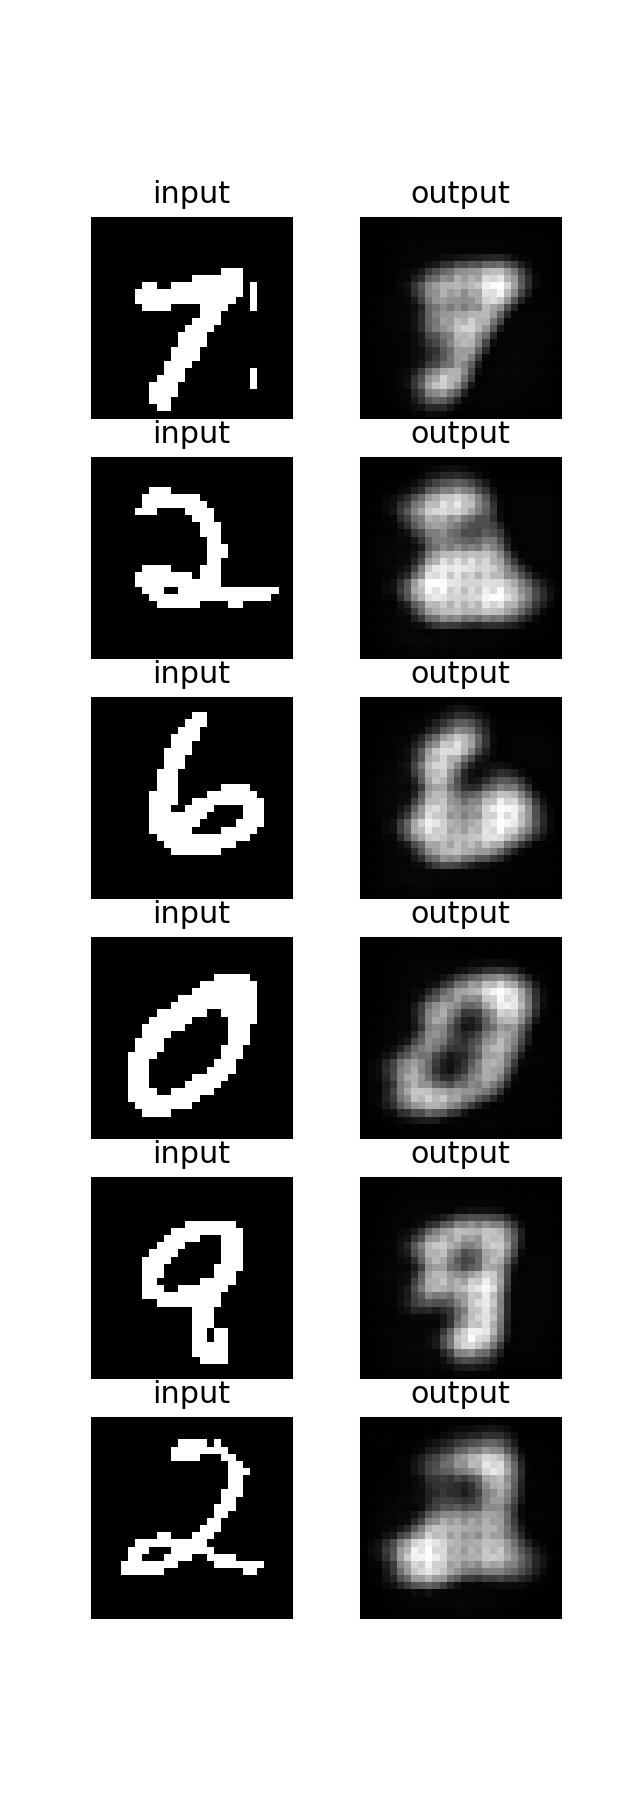

In [302]:
x_val_preds = model.predict(x_val)

examples = np.random.randint(0, high=x_val.shape[0], size=6)
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(3.5,10))
# fig.suptitle('Examples', fontsize=16)
for ynum in range(6):
    ax = axs[ynum, 0]
    ax.imshow(x_val[examples[ynum], :, :, 0], cmap='gray')
    ax.set_title('input', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = axs[ynum, 1]
    ax.imshow(x_val_preds[examples[ynum], :, :, 0], cmap='gray')
    ax.set_title('output', fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])

### Look at the weights, particularly of the dense_7 layer (14) and dense_8 layer (15)

In [ ]:
# Print the number of weights for each layer
n_layers = len(model.layers)
for layer_no in range(n_layers):
    print('-- Layer number %i: %s --' % (layer_no, model.layers[layer_no].name))
    try:
        weights = model.layers[layer_no].get_weights()[0]
    except IndexError:
        print('None')
    else:
        print(weights.shape)

(1568, 80)


<IPython.core.display.Javascript object>


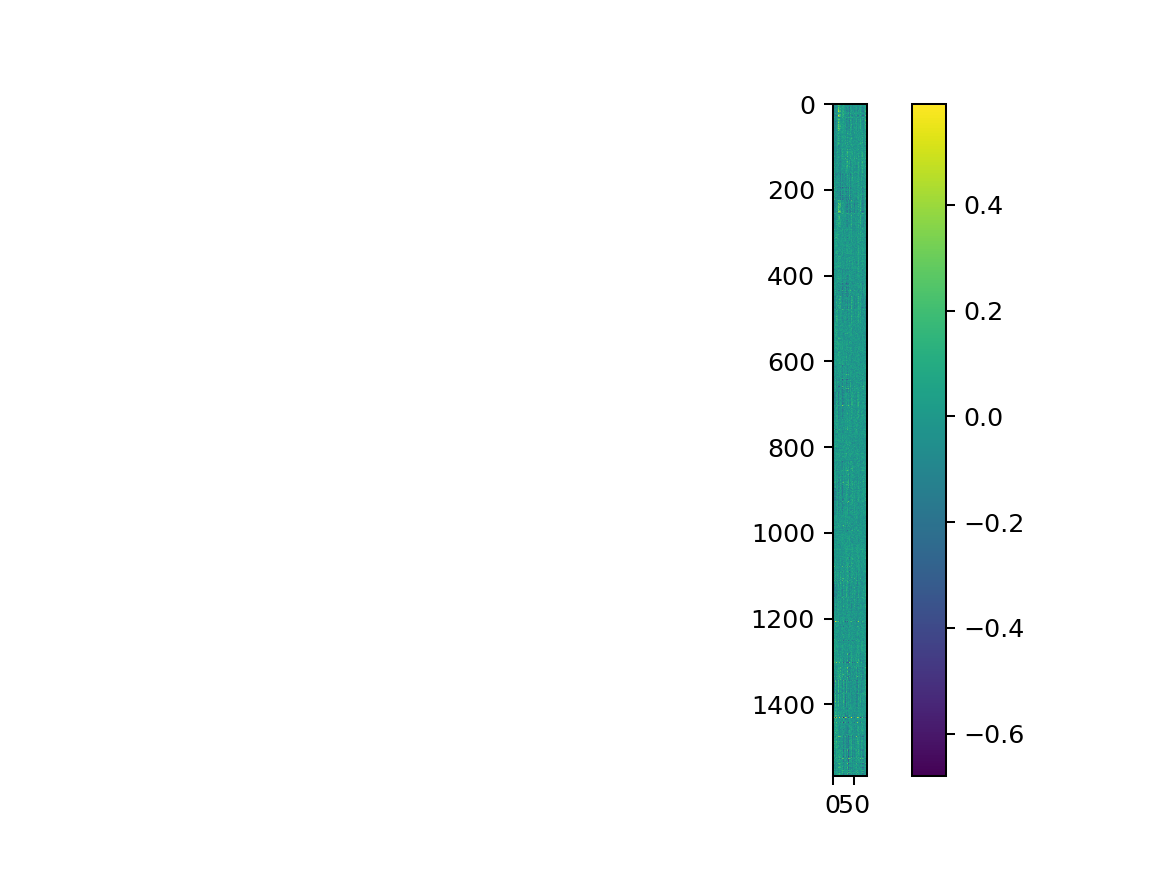

In [279]:
layer_no = 12
layer_name = model.layers[layer_no].name
weights = model.layers[layer_no].get_weights()[0]
print(weights.shape)
plt.figure()
plt.imshow(weights)
plt.colorbar()

## Autoencoder clustering of dense layer.

In [303]:
layer_name = 'Dense_7'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x_val)

In [304]:
intermediate_output.shape
x_embedded = TSNE().fit_transform(intermediate_output)


<IPython.core.display.Javascript object>


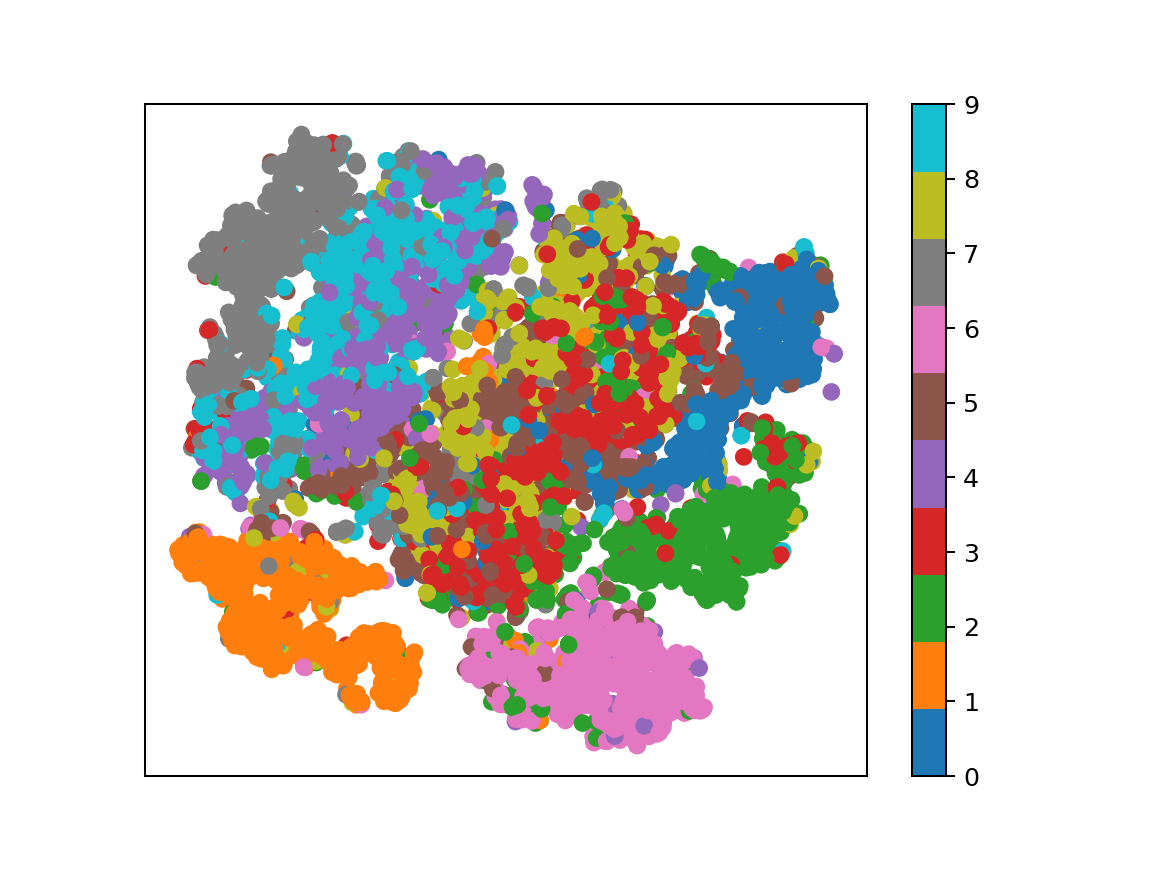

(10000, 2)


In [305]:
plt.figure()
print(x_embedded.shape)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=y_val, cmap='tab10')
plt.xticks([])
plt.yticks([])
plt.colorbar()